<p align="center">
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>01. EDA</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

## 1.0 Introducción

En este notebook se realizará un análisis exploratorio de los datos, a fin de poder entender mejor el dataset de cara a realizar el posterior tratamiento y la estimación de los modelos. Se trata de una parte fundamental, pues un correcto EDA permitirá responder a las preguntas de negocio de una manera más precisa, y elaborar unos modelos mejores.

Es IMPORTANTE haber revisado previamente el notebook ```00.Introducción```, en el cual se explican los objetivos de negocio que se tendrán en cuenta al elaborar este análisis.

Este trabajo utiliza un entorno de propósito espécifico.

In [1]:
# Verificamos el entorno: ML_P1
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 1.0.1 Objetivo de negocio
A continuación repasamos el objetivo de negocio marcado. Ayudar a la toma de decisión de cuanto capital inmovilizar para cubrir contingencias derivadas de accidentes de tráfico. Es por ello que buscamos desarrollar un modelo que permita predecir la posibilidad de fallecimientos en un accidente en función de sus características.

### 1.0.2 Estructura
0. Librerías
1. Los Datos
    * Importanción
    * Diccionario de Datos
    * Información concodia
2. EDA
    * Análisis de tipos
    * Análisis de valores especiales
    * Análisis de valores missings
    * Repeticiones en el dataset
    * Análisis de variable objetivo
    * Análisis de variables continuas
    * Análisis de variables categóricas 
        * Algunas preguntas interesantes y sus respuestas
3. Conclusiones

## Librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import nbconvert

%matplotlib inline

## Scripts

Trabajamos con script propio donde se encuentran funciones propias. 

In [3]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools

## 1.1 Los Datos

Primer vistazo a los datos

### 1.1.1 Importación

<< REVISAR TEMA PARQUET >>

In [4]:
# accidents_df = pd.read_parquet("../data/NCDB_1999_to_2014.parquet")

# Función propia que verifica que existe el fichero de datos previamente.
accidents_df = csv_tools.csv_import(origin = '../data/NCDB_1999_to_2014.csv')

Reading file...
Reading ended.


In [5]:
accidents_df.head(5)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,01,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,01,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [6]:
print('Total de filas del dataset: ', len(accidents_df.index))

Total de filas del dataset:  5860405


In [7]:
print('Total de columnas del dataset: ', len(accidents_df.columns))

Total de columnas del dataset:  22


### 1.1.2 Diccionario de datos
En el Diccionario de Datos, se explica de forma detallada la información correspondiente a cada variable. Este puede encontrarse en la carpeta ```docs``` del repositorio con el nombre ```DiccionarioDatosESP.pdf```. En el hemos introducido brevemente el dataset, explicando de forma detalla cada variable del mismo. A continuación revisamos su contenido.

El dataset a utilizar es Canadian Car Accidents (```NCDB_1999_to_2014.csv```). Este proporciona información relativa a accidentes por colisiones de vehículos en Canada. A prior, podemos comentar que este dataset posee un total de **22 variables de estudio** o columnas. Que se agrupan en tres grupos: **Datos relativos al accidente**, **Datos relativos al vehículo** y **Datos relativos a la persona(s) involucradas**. 

En concreto, la información que se posee es respectivo a personas, es decir, tenemos un registro de cada persona del accidente, el vehículo en el cual iba y los datos de su accidente. Analicemos un ejemplo para entender adecuadamente la información que contiene este dataset:

1. Veamos el primer accidente registrado en el dataset, que se corresponden con enero de 1999:

In [8]:
# Accidente a analizar
first_accident = accidents_df[(accidents_df['C_YEAR'] == 1999) & (accidents_df['C_MNTH'] == '01') &
            (accidents_df['C_WDAY'] == '1') & (accidents_df['C_HOUR'] == '20') &
             (accidents_df['C_SEV'] == 2) & (accidents_df['C_VEHS'] == '02') &
              (accidents_df['C_CONF'] == '34') & (accidents_df['C_RCFG'] == 'UU') & 
               (accidents_df['C_WTHR'] == '1') & (accidents_df['C_RSUR'] == '5') &
                (accidents_df['C_RALN'] == '3') & (accidents_df['C_TRAF'] == '03')]

In [9]:
# Datos del accidente
acc_columns = ['C_YEAR', 'C_MNTH', 'C_WDAY', 
               'C_HOUR', 'C_SEV', 'C_VEHS', 
               'C_CONF', 'C_RCFG', 'C_WTHR', 
               'C_RSUR', 'C_RALN', 'C_TRAF']
first_accident[acc_columns]

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF
0,1999,01,1,20,2,02,34,UU,1,5,3,03
1,1999,01,1,20,2,02,34,UU,1,5,3,03
2,1999,01,1,20,2,02,34,UU,1,5,3,03


Podemos observar el accidente ocurrido: 
* ¿Cuándo?: En la primera semana (```C_WDAY```) de Enero (```C_MNTH```) de año 1999 (```C_YEAR```).
* No hubo fallecidos (```C_SEV```). 
* Había dos vehículos implicados (```C_VEHS```).
* El accidente fue de dos vehículos en sentido opuesto al girar a la derecha en un cruce. (```C_CONF```)
* Se desconoce la configuración de la carretera. (```C_RCFG```)
* Hacía un día soleado y claro. (```C_WTHR```)
* El asfalto estaba congelado. (```C_RSUR```)
* En una curva sin desnivel. (```C_RALN```)
* Había una señal de stop. (```C_TRAF```)

Observamos que se repite tres veces, esto ya nos indica que hay tres personas implicadas.

In [10]:
# Datos de los vehículos
car_columns = ['V_ID', 'V_TYPE', 'V_YEAR']
first_accident[car_columns]

,V_ID,V_TYPE,V_YEAR
0,01,06,1990
1,02,01,1987
2,02,01,1987


En cuanto a los vehículos implicados, observamos dos, si bien uno de ellos se repite dos veces, pues en ese viajaban dos personas. El primer vehículo es del año 1990 (```V_YEAR```) y es de tipo 6 (```V_TYPE```). El segundo es del año 1987 y es de pasajeros o servicio auxiliar. 

In [11]:
# Datos de las personas
per_columns = ['P_ID', 'P_SEX', 'P_AGE', 
               'P_PSN', 'P_ISEV', 'P_SAFE',
               'P_USER']
first_accident[per_columns]

,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,01,M,41,11,1,UU,1
1,01,M,19,11,1,UU,1
2,02,F,20,13,2,02,2


Ahora ya podemos analizar a las tres personas implicadas. 

En el primer vehículo, viaja solo una (```P_ID```). Tiene 41 años (```P_ADE```), es hombre (```P_SEX```) y, evidentemente, conducía el vehículo (```P_USER```) y por lo tanto estaba en la posición del conducto (```P_PSN```). Después del accidente salió ileso (```P_ISEV```). Se desconoce si llevaba o utilizaba algún dispositivo de seguridad (```P_SAFE```).

En el segundo vehículo, había dos personas. Un hombre de 19 años que conducía el vehículo, y que salió ileso del accidente. La mujer de 20 años iba de pasajera en el asiento delantero derecho. Por desgracia salió herida del accidente pese a utilizar un dispositivo de seguridad (cinturón).

Como podemos observar el dataset nos da información bastante detallada de los accidentes al nivel de las personas involucradas en los mismos.

Podemos observar todos los valores que pueden tomar las variables del dataset:

In [12]:
for col in accidents_df.columns:
    print(col)
    print(accidents_df[col].unique())
    if (col != 'P_USER'): 
        print('-------------------------')

C_YEAR
[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014]
-------------------------
C_MNTH
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' 'UU']
-------------------------
C_WDAY
['1' '2' '3' '4' '5' '6' '7' 'U']
-------------------------
C_HOUR
['20' '08' '17' '15' '14' '01' '11' '13' '19' '16' '09' '02' '18' '12'
 '10' '23' '00' '06' '07' '21' 'UU' '05' '22' '03' '04']
-------------------------
C_SEV
[2 1]
-------------------------
C_VEHS
['02' '01' '03' '04' '06' '07' '09' 'UU' '05' '13' '08' '12' '14' '10'
 '11' '16' '26' '71' '19' '25' '21' '27' '15' '35' '22' '41' '46' '31'
 '18' '56' '23' '36' '17' '20' '29' '77' '28' '38' '32' '33' '54' '72'
 '40' '44' '58' '30' '24' '34' nan '39' '51' '57' '43' '37']
-------------------------
C_CONF
['34' '01' 'QQ' '04' '31' '21' '23' '03' '02' '33' 'UU' '24' '35' '41'
 '06' '32' '36' '05' '22' '25']
-------------------------
C_RCFG
['UU' 'QQ' '01' '02' '03' '05' '04' '06' '08' '07' '09' '10']
------

### 1.1.3 Información conocida
Es relevante comentar antes de comenzar con el análisis de toda la inforamación que poseemos cual podemos utilizar para conocer la severidad de un accidente. 

A priori, la columna que parece que tenemos que utilizar como variable objetivo es la severdidad del accidente (```C_SEV```). Por otro lado, parece razonable pensar que tendremos casi toda la información mencionada disponible para determinar si hay probabilidades de fallecimiento o no. Pero la columna ```P_ISEV``` que hace referencia al estado de la persona después del accidente no será conocida. 

## 1.2 Análisis: EDA

### 1.2.1 Análisis de tipos
Analizamos el número de columnas, sus nombres y tipos:

In [13]:
print('Listado de columnas con su respectivo tipo de dato')
print('--------------------------------------------------')
types_df = accidents_df.dtypes.reset_index()
types_df.columns = ['columna', 'tipo_dato']
types_df

Listado de columnas con su respectivo tipo de dato
--------------------------------------------------


,columna,tipo_dato
0,C_YEAR,int64
1,C_MNTH,object
2,C_WDAY,object
3,C_HOUR,object
4,C_SEV,int64
5,C_VEHS,object
6,C_CONF,object
7,C_RCFG,object
8,C_WTHR,object
9,C_RSUR,object


Podemos observar que la mayoría de columnas son tratados como ```object```. Es extraño pues un primer vistazo con la función ```head``` a mostrado que en su mayoría se corresponden con valores enteros, los que sabemos, por el diccionario de datos elaborado, se refieren a categorías. Un estudio más detenido de los datos nos enseña la existencia de valores especiales que justifican la lectura de estas columnas como ```object```, los cuales estudiamos a continuación.

### 1.2.2 Análisis de valores especiales

Estudiamos valores especiales del dataset.

En este dataset los valores especiales se clasifican en tres tipos:
* ```Q```: Este valor indica que se corresponde con una categoría distinta a las demás.
* ```N```: Este valor indica que el criterio de valoración no es aplicable. Este se corresponde generalmente, con tuplas que son valores dummies y por lo tanto no necesita esta información.
* ```U```: Este valor indica que se desconoce, un valor faltante.
* ```X```: Este valor indica que el valor está clasificado y no ha sido proporcionado.

Estos valores, si bien son universales al dataset, no están presentes en todas las variables. Además se presentan de distinta manera, pudiendo presentarse de los siguientes formatos: ```U```, ```UU``` y ```UUUU```.

Estos valores no representan la misma información y por lo tanto deberán tratarse de forma distinta.

A continuación, presentamos una tabla resumen de la existencia de estos valores en el dataset. Cada columna referencia el número de ocurrencias de cada valor (en cualquiera de sus formas) en la columna, el porcentaje sobre el total de valores de la columna, y también el total de los cuatro tipos.

In [14]:
def special_values_summary(df = None, vals = []):
    # Conteo y porcentajes
    cols_svals_df = pd.DataFrame(data = df.columns, columns = ['column_name'])
    
    sum_column = pd.DataFrame(0, index=np.arange(len(cols_svals_df.index)), columns=['store'])

    # Bucle de creación de columnas de conteo
    for value in vals:
    
        totals = list()
        for col in cols_svals_df['column_name']:
            totals.append(df[df[col].isin(value)][col].count())
        
        cols_svals_df[value[0]] = totals
        sum_column['store'] = sum_column['store'] + cols_svals_df[value[0]]
    
        percentajes = list()
        for col in cols_svals_df['column_name']:
            percentajes.append(np.round(cols_svals_df[cols_svals_df['column_name'] == col][value[0]] / 
                                        len(df.index) * 100, decimals = 3).values)
        
        cols_svals_df[value[0] + '%'] = percentajes
    

    cols_svals_df['total'] = sum_column['store']
    cols_svals_df['total%'] = np.round(cols_svals_df['total'] / len(df.index) * 100, decimals = 1)
    return cols_svals_df

In [15]:
# Valores especiales
Q = ['Q', 'QQ', 'QQQQ']
N = ['N', 'NN', 'NNNN']
U = ['U', 'UU', 'UUUU']
X = ['X', 'XX', 'XXXX']
vals_hists = [Q, N, U, X]
    
sum_svals_df = special_values_summary(df = accidents_df, vals = vals_hists)

In [16]:
sum_svals_df

,column_name,Q,Q%,N,N%,U,U%,X,X%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],0,[0.0],385,[0.007],0,[0.0],385,0.0
2,C_WDAY,0,[0.0],0,[0.0],1323,[0.023],0,[0.0],1323,0.0
3,C_HOUR,0,[0.0],0,[0.0],59409,[1.014],0,[0.0],59409,1.0
4,C_SEV,0,[0.0],0,[0.0],0,[0.0],0,[0.0],0,0.0
5,C_VEHS,0,[0.0],0,[0.0],541,[0.009],0,[0.0],541,0.0
6,C_CONF,284980,[4.863],0,[0.0],179019,[3.055],0,[0.0],463999,7.9
7,C_RCFG,144298,[2.462],0,[0.0],504648,[8.611],0,[0.0],648946,11.1
8,C_WTHR,15013,[0.256],0,[0.0],87975,[1.501],0,[0.0],102988,1.8
9,C_RSUR,170217,[2.905],0,[0.0],78451,[1.339],0,[0.0],248668,4.2


In [17]:
# Guardar resultados (CUIDADO: sobreescritura del archivo)
# sum_svals_df.to_csv("../data/NCBD_sval_summary.csv")

Este análisis de existencia de variables especiales demuestra que la variable ```C_SEV```, la que nos indica la existencia de fallecidos en el accidente, no posee valores especiales. Por lo que a priori, si bien todavía no hemos finalizado el EDA de este dataset, esta sería nuestra variable candidata a elaborar el modelo.

Por otro lado, podemos determinar que la variable ```P_SAFE```, que indica las medidas de seguridad presentes en el vehículo, es la que posee un alto porcentaje de valores especiales (21%). Seguida por ```C_RCFG``` con 11% y ```V_YEAR``` con 10%.

### 1.2.3 Valores missing o faltantes
Por otro lado existen unas variables propiamente nulas en el modelo, que podemos observar a continuación:

In [18]:
# Columnas donde existen valores nulos, es decir, NAs
temp_df = accidents_df.isnull().sum().reset_index()
temp_df.columns = ['column_name', 'NAs']
temp_df[temp_df.NAs > 0]

,column_name,NAs
5,C_VEHS,3


Observamos que en al columna de número de vehículos involucrados en un accidente existen tres valores nulos. 

### 1.2.4 Repeticiones en el dataset
A continuación vamos a analizar la existencia de tuplas repetidas en el dataset que tenemos. Cuando mostramos las 6 primeras filas de este dataframe pudimos observar como existian valores repetidos en las primeras columnas del dataframe, referentes a la información de accidentes, pero sin embargo la información correspondiente a vehiculos y personas se iba diferenciando.

Veamos una agregación por accidentes, es decir, varibales ```C_*```:

In [19]:
acc_columns = ['C_YEAR', 'C_MNTH', 'C_WDAY', 
               'C_HOUR', 'C_SEV', 'C_VEHS', 
               'C_CONF', 'C_RCFG', 'C_WTHR', 
               'C_RSUR', 'C_RALN', 'C_TRAF']


acc_group_df = accidents_df.groupby(acc_columns).count()['V_ID']
acc_group_df.columns = ['total_rows']
acc_group_df = acc_group_df.reset_index()
acc_group_df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID
0,1999,01,1,00,2,01,01,01,1,4,1,18,1
1,1999,01,1,00,2,01,01,01,1,5,1,18,1
2,1999,01,1,00,2,01,01,01,2,1,1,18,1
3,1999,01,1,00,2,01,01,01,6,3,2,18,2
4,1999,01,1,00,2,01,01,UU,1,2,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850390,2014,12,7,UU,2,02,UU,02,U,U,1,03,2
1850391,2014,UU,U,14,2,01,02,01,1,5,4,18,1
1850392,2014,UU,U,22,1,01,06,01,2,4,Q,18,2
1850393,2014,UU,U,23,2,01,06,05,1,1,U,18,1


In [20]:
# Guardar resultados (CUIDADO: Sobreescritura del fichero)
# acc_group_df.to_csv("../data/NCBD_group_accident.csv")

Podemos observar un total de 1.850.395 filas, que se corresponden con los distintos accidentes registrados en el dataset.

### 1.2.5 Estudio de variables objetivo

In [21]:
# Calcula el porcnetjae y valor abosoluto de las clases de la variable objetivo.
def classes_overview(df = None, obj_val = ""):
    temp = df[obj_val].value_counts(normalize=True).mul(100).rename('percentaje').reset_index()
    temp_conteo = df[obj_val].value_counts().reset_index()
    return pd.merge(temp, temp_conteo, on=['index'], how='inner')

#### 1.2.5.1 Variable ```C_SEV```
Como hemos comentado en el diccionario de datos y en consecución con el objetivo de negocio, hemos seleccionado como variable objetivo la severidad del accidente. Procedemos a analizarla:

In [22]:
classes_overview(df = accidents_df, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,2,98.316959,5761772
1,1,1.683041,98633


Observamos que existen casi un 2% de casos donde hay almenos un fallecido, mientras que el resto son respecto a que no hubo fallecidos. Esto es muy relevante pues tendremos que tenerlo en cuenta para preprocesar adecuadamente el dataset previo a su uso en el modelo.

Agrupado por accidentes, los porcentajes son similares (evidentemente). De todos modos resulta interesante para conocer con cuantos accidentes contamos.

In [23]:
classes_overview(df = acc_group_df, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,2,98.063116,1814555
1,1,1.936884,35840


#### 1.2.5.2 Variable: ```P_ISEV```

La otra variable objetivo del modelo es ```P_ISEV```, que tal y como se especifica en el diccionario de datos, se corresponde con el grado de severidad de los implicados en el siniestro. Es decir, si en un accidente una persona ha salido **ilesa** (1), resultó **herida** (2) o ha **fallecido** (3).

In [24]:
classes_overview(df = accidents_df, obj_val = 'P_ISEV')

,index,percentaje,P_ISEV
0,2,52.444003,3073431
1,1,40.529759,2375208
2,N,4.960596,290711
3,U,1.377055,80701
4,3,0.688587,40354


### 1.2.6 Estudio de variables continuas
A prori, la única variable continua con la que disponemos y podemos realizar un análisis de correlaciones es el año. Si bien existen otras variables (identificadas a priori como categóricas) que también son continuas y que requeriran una conversión, pues su lectura como objeto se debe a la existencia de valores especiales:
* ```C_YEAR``` (leida correctamente)
* ```C_VEHS``` (necesita conversión)
* ```V_YEAR``` (necesita conversión)
* ```P_AGE``` (necesita conversión)


Para poder analizar todas estas variables procederemos a realizar una conversión en esta fase del análisis.

In [25]:
# Conversión parcial
numeric_var = ['C_YEAR', 'C_VEHS', 'V_YEAR', 'P_AGE']
accidents_temp = accidents_df

# Valores especiales
Q = ['Q', 'QQ', 'QQQQ']
N = ['N', 'NN', 'NNNN']
U = ['U', 'UU', 'UUUU']
X = ['X', 'XX', 'XXXX']
vals_hist = [Q, N, U, X]

for val in vals_hist: #reusamos el array de valores especiales
    accidents_temp = accidents_temp.replace(val, np.nan)

accidents_temp[numeric_var] = accidents_temp[numeric_var].astype(float)

In [26]:
# Guardar resultados (CUIDADO: sobreescritura del fichero)
# accidents_temp.to_csv("../data/NCBD_partial_num_float.csv")

In [27]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()

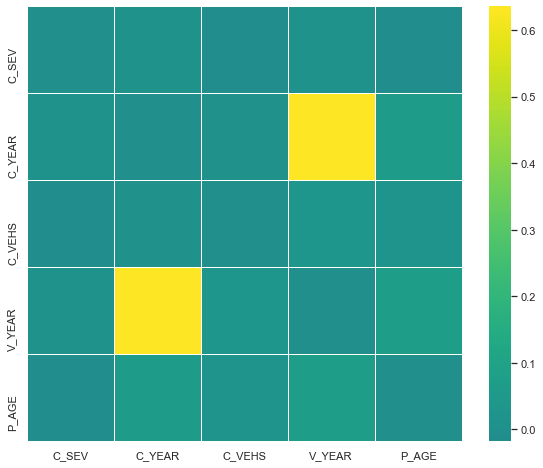

In [28]:
numerical = ['C_SEV', 'C_YEAR', 'C_VEHS', 'V_YEAR', 'P_AGE']
get_corr_matrix(dataset = accidents_temp[numerical], metodo = 'pearson')

Se observa una baja correlación a nivel general de las variables con la variable objetivo. Por otro lado cabe destacar la correlación existentes en las variables que se refieren a años, aspecto que resulta evidente al ser ambas variables sobre años.

Representemos ahora algunas con el objetivo de detectar outliers

<AxesSubplot:>

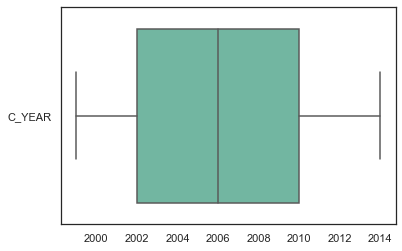

In [29]:
sns.boxplot(data=accidents_temp[['C_YEAR']].dropna(), orient="h", palette="Set2")

<AxesSubplot:>

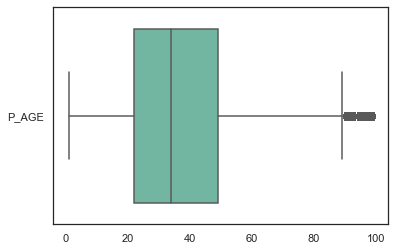

In [30]:
sns.boxplot(data=accidents_temp[['P_AGE']].dropna(), orient="h", palette="Set2")

Podemos describrir el boxplot de ```P_AGE```, donde podemos observar algunos outliers en lado derecho. Es importante mencionar que se deba a aque existen pocas personas en estos datos con edades avanzadas. Por otro lado, el valor 99 se asigna a personas con esa edad o superior, según el análisis previo en nuestro diccionario de datos.

Finalmente, veamos una descripción de cada valor:

In [31]:
accidents_temp.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,C_YEAR,C_SEV,C_VEHS,V_YEAR,P_AGE
count,5.8604e+06,5.8604e+06,5.85986e+06,5.27603e+06,5.46525e+06
mean,2006,1.98317,2.04577,1998.51,36.399
std,4.56989,0.128636,1.26879,7.12669,18.3692
min,1999,1,1,1901,1
25%,2002,2,2,1994,22
50%,2006,2,2,1999,34
75%,2010,2,2,2004,49
max,2014,2,77,2015,99


Es relevante mencionar que el conteo de valores (que se esperaría que fuera el mismo) no es igual para los valores de las variables ```C_VEHS```, ```V_YEAR``` y ```P_AGE```, pues cuentan con valores especiales (identificados como nulos). 

Destacamos que existe un accidente con 77 vehículos implicados, es posible que se trate de un accidente múltiple. Y también observamos un registro extraño: En ```V_YEAR``` existen vehículos del 2015, pero estos accidentes son hasta el año 2014, por lo que, a priori, no es posible que un vehículo fabricado en 2015 tenga un accidente en 2014.

Busquemos este valor:

In [32]:
accidents_df[accidents_df['V_YEAR'] == '2015'].groupby(acc_columns).count()

V_ID  \
C_YEAR C_MNTH C_WDAY C_HOUR C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR C_RALN C_TRAF         
2014   01     3      14     2     02     33     02     1      1      1      01         1   
       02     3      01     2     02     31     01     6      5      1      18         1   
              6      18     2     02     35     01     1      Q      1      18         1   
              7      19     2     02     35     02     1      1      1      01         1   
       03     2      18     2     03     21     01     1      1      1      18         1   
...                                                                                  ...   
       12     7      18     1     01     06     01     1      1      2      18         4   
                            2     03     21     01     2      2      2      01         2   
                                  04     21     01     1      1      1      18         1   
                     20     1     02     23     02     2      5      1      18         1   
                     22     2     02     35     UU     1      2      U      01         1   

                                                                                    V_TYPE  \
C_YEAR C_MNTH C_WDAY C_HOUR C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR C_RALN C_TRAF           
2014   01     3      14     2     02     33     02     1      1      1      01           1   
       02     3      01     2     02     31     01     6      5      1      18           1   
              6      18     2     02     35     01     1      Q      1      18           1   
              7      19     2     02     35     02     1      1      1      01           1   
       03     2      18     2     03     21     01     1      1      1      18           1   
...                                                                                    ...   
       12     7      18     1     01     06     01     1      1      2      18           4   
                            2     03     21     01     2      2      2      01           2   
                                  04     21     01     1      1      1      18           1   
                     20     1     02     23     02     2      5      1      18           1   
                     22     2     02     35     UU     1      2      U      01           1   

                                                                                    V_YEAR  \
C_YEAR C_MNTH C_WDAY C_HOUR C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR C_RALN C_TRAF           
2014   01     3      14     2     02     33     02     1      1      1      01           1   
       02     3      01     2     02     31     01     6      5      1      18           1   
              6      18     2     02     35     01     1      Q      1      18           1   
              7      19     2     02     35     02     1      1      1      01           1   
       03     2      18     2     03     21     01     1      1      1      18           1   
...                                                                                    ...   
       12     7      18     1     01     06     01     1      1      2      18           4   
                            2     03     21     01     2      2      2      01           2   
                                  04     21     01     1      1      1      18           1   
                     20     1     02     23     02     2      5      1      18           1   
                     22     2     02     35     UU     1      2      U      01           1   

                                                                                    P_ID  \
C_YEAR C_MNTH C_WDAY C_HOUR C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR C_RALN C_TRAF         
2014   01     3      14     2     02     33     02     1      1      1      01         1   
       02     3      01     2     02     31     01     6      5      1      18         1   
              6      18     2     02     35     01     1      Q      1   

Es posible que tengamos que eliminar estas filas pues poseen información no coherente. 

Por otro lado podemos observar esos accidentes múltiples:

In [33]:
accidents_df[accidents_df['C_VEHS'] == '77'].groupby(acc_columns).count()

,,,,,,,,,,,,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,,,,,,,,,,
2006,02,5,13,1,77,21,QQ,6,1,2,18,113,113,113,113,113,113,113,113,113,113
2013,01,5,15,2,77,21,01,4,3,2,18,116,116,116,116,116,116,116,116,116,116


### 1.2.7 Estudio de variables categóricas
Después de este análisis y el estudio del diccionario de datos, casi en su totalidad las columnas del dataset son categóricas. A excepción de las referentes a año o meses. A continuación, procederemos a analizar las variables categóricas respecto a la variable objetivo seleccionada.

Al analizar la variable categórica, pudimos ver que existe un importante desiquilibrio, pues poseemos una gran cantidad de variables de accidentes no mortales, en comparación con los accidentes con al menos una víctima mortal. Para poder comparar las variables categóricas haremos una normalización por grupos, de tal forma que el conjunto de valores registrados de una categoría se normalizará por el total de accidentes mortales o no mortales. Creamos para ello una función que reutilizaremos:

In [34]:
def norm_category(df = None, obj_val = "", cat_val = ""):
    grouped = df.groupby([obj_val, cat_val]).count().iloc[:,1]
    grouped = grouped.reset_index()
    grouped.columns = [obj_val, cat_val, 'counted']
    grouped['group%'] = np.round(grouped['counted'] / 
                                 grouped.groupby(obj_val)['counted'].transform('sum') * 100, decimals = 3)
    return grouped

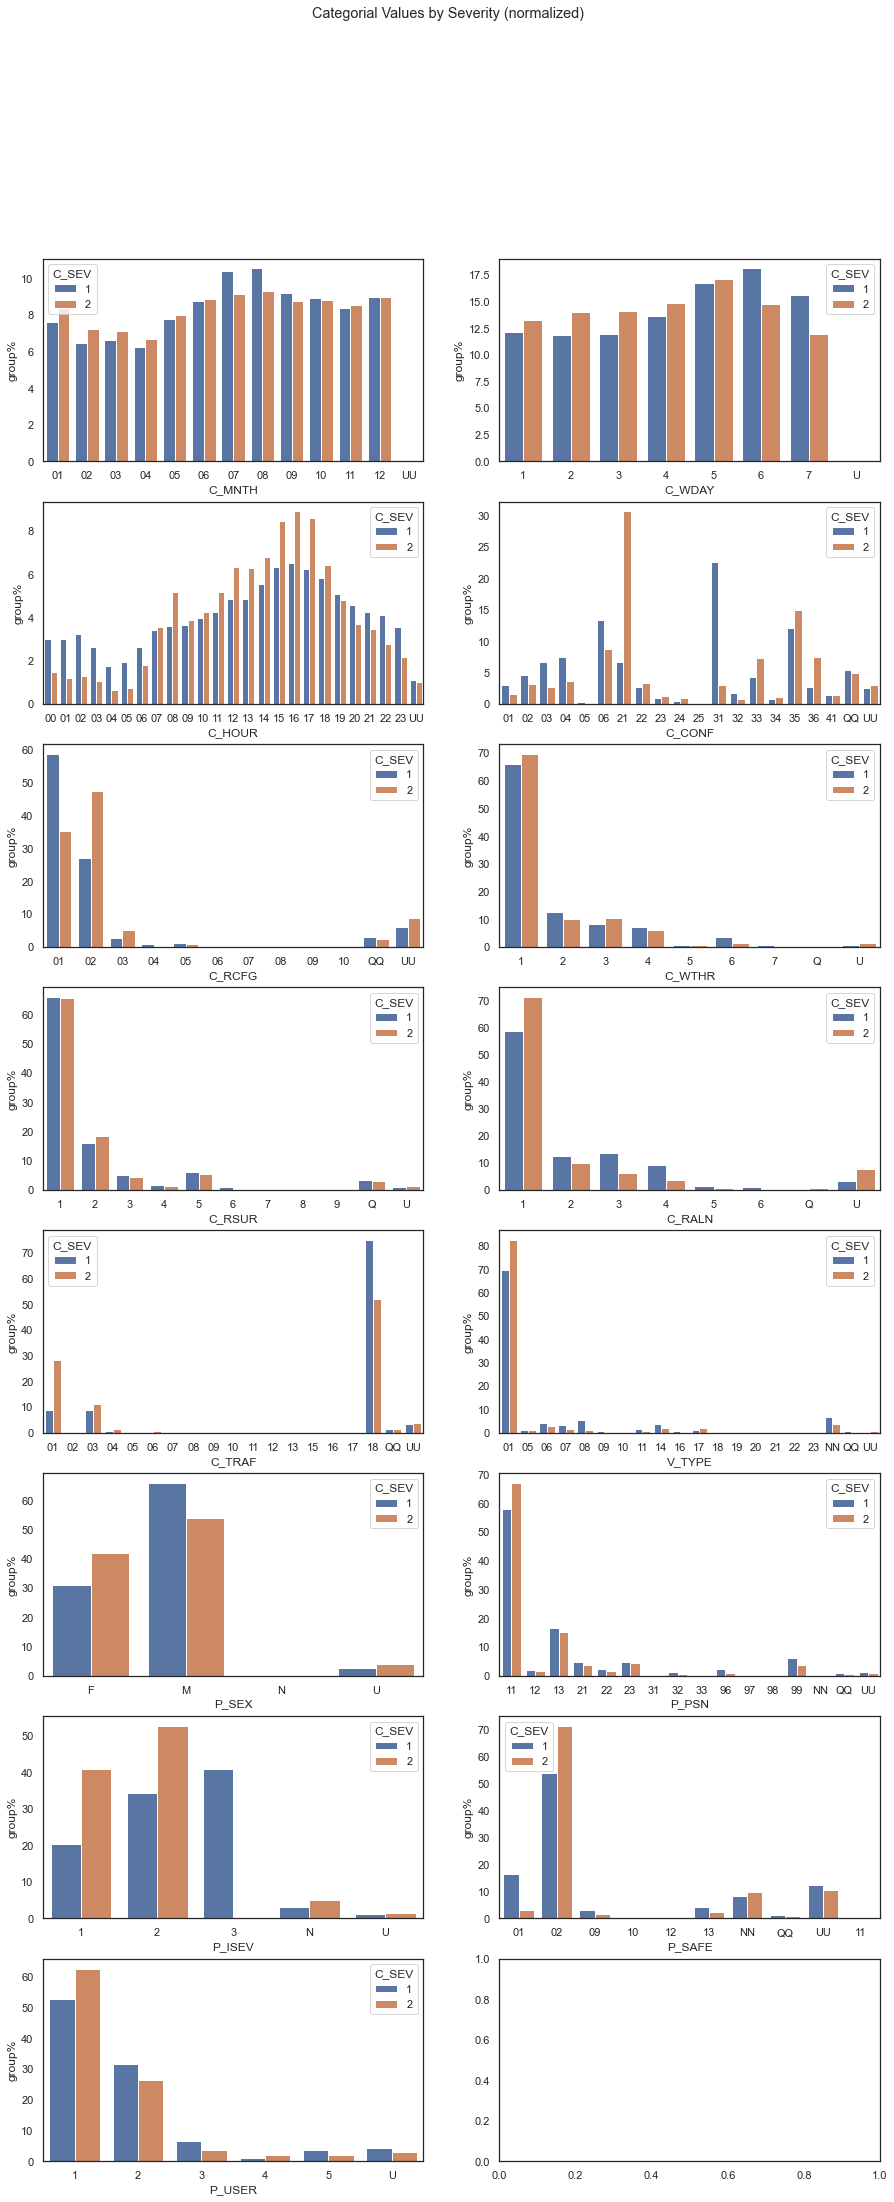

In [35]:
categorical = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 
               'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 
               'C_TRAF', 'V_TYPE', 'P_SEX', 'P_PSN', 
               'P_ISEV', 'P_SAFE', 'P_USER']

fig, axes = plt.subplots(8, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0
j = 0
for cat in categorical:
    temp = norm_category(df = accidents_df, obj_val = 'C_SEV', cat_val = cat)
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'C_SEV', ax = axes[i,j]);
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

Algunas ideas tras visualizar los gráficos:

Observamos como los accidentes son más mortales durante los meses de julio y agosto. Esto parece razonable pues son los meses vacacionales donde las personas realizan mayor cantidad de viajes y desplazamientos, y por lo tanto es altamente probable que ocurran accidentes graves durante esas fechas. También se evidencia que en los fines de semana (sábado y domingo), aumenta la probabilidad tienen de sufrir accidentes mortales. En estos periodos no laborales generalmente es cuando más viajes se realizan.

En lo relativo a la meteorología, la mayor parte de los accidentes tienen lugar en condiciones meterorológicas favorables (despejado o soleado), aunque la mortalidad que tienen es menor. Por el contrario, ante situaciones como día nublado, nieve o visibilidad limitada existe una mayor probabilidad de muerte. Resulta curios ver como ante días lluviosos la severidad es menor. 

Por otro lado, algo llamativo con esta gráfica es que observamos un desequilibrio en esta muestra, pues casi todos los valores que se poseen son referentes a accidentes en días soleados. Lo que perjudica a la hora de que esta variable pueda ser determinante para valorar la severidad del accidente, es decir, puede existir un sesgo que afecte a nuestro modelo. Esta situación se puede observar en otras variables, por lo que tendremos que tener en cuenta este hecho a la hora de seleccionar variables.

#### Algunas respuestas a raíz del análisis

Respondamos a algunas preguntas interesantes:

1. **¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?**

Observando las gráficas podemos determinar que los vehículos de carga y transporte suelen tener mayor porcentaje de accidentes.
En cuanto a la antiguedad podemos analizar a continuación la siguiente gráfica:

<function seaborn.rcmod.reset_orig()>

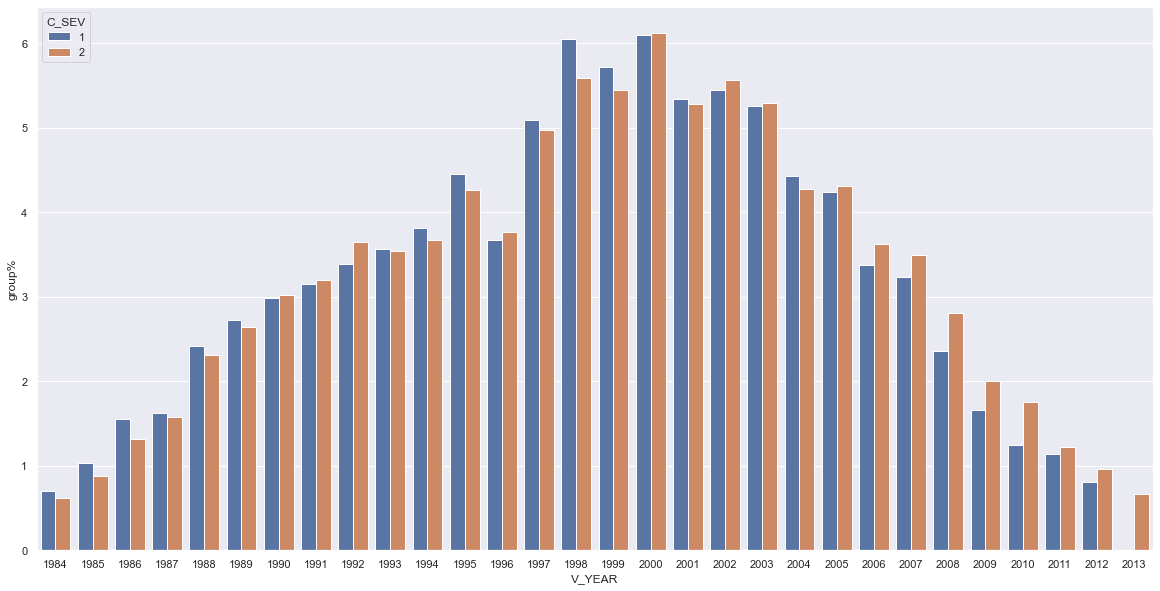

In [36]:
vyear_df = accidents_df[accidents_df['V_YEAR'].isin(['NNNN', 'UUUU']) != True]
vyear_df = norm_category(df = vyear_df, obj_val = 'C_SEV', cat_val = 'V_YEAR')
vyear_df = vyear_df[vyear_df['group%'] > 0.5]

sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data = vyear_df, x = 'V_YEAR', y = 'group%', hue = 'C_SEV');
sns.reset_orig

Podemos observar como vehículos más antiguos tienen más accidentes mortales, que los vehículos más nuevos. Si bien la muestra se concentra en los vehículos fabricados entre el 1997 y 2004

Por otro lado, analizando las edades de los conductores:


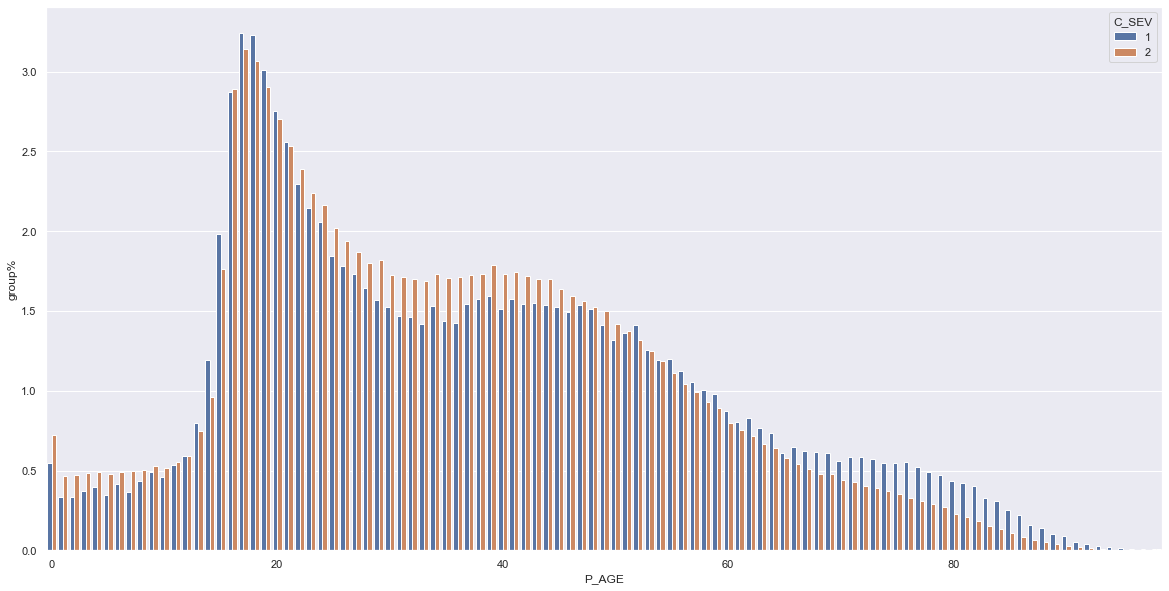

<function seaborn.rcmod.reset_orig()>

In [37]:
page_df = accidents_df[(accidents_df['P_AGE'].isin(['NN', 'UU']) == False)]
page_df = norm_category(df = page_df, obj_val = 'C_SEV', cat_val = 'P_AGE')

sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data = page_df, x = 'P_AGE', y = 'group%', hue = 'C_SEV');
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.show()
sns.reset_orig

Respecto a al edad se observa que conductores jovenes con una experiencia mayor conduciendo tienen más accidentes. 
Por otro lado personas mayores en edades avanzadas. Por otro lado los accidentes se concentran en personas jovenes/adultas. 
En cuanto al sexo, la mayoría de conductores registrados con accidentes son hombres, si bien también hay un alto porcentaje en mujeres, por lo que no podemos considerarlo un hecho muy diferenciador.

2. **¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?**

Estudiando las gráficas obtenidas anterioremente. Se pued observar que los vehículos más nuevos tienen menos accidentes mortales. Por otro lado, conductores jóvenes, con carnet recien obtenido suelen tener menos accidentes, así como conductes en edad media y con una mayor experiencia al volante. 

3. **¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?**

Podemos realizar un pequeño análisis de las variables a nivel visual:
* Observamos que la tipología del accidente afecta a la mortalidad del mismo. Por ejemplo los accidentes frontales tienen un elevado porcentaje de mortalidad.
* La señalización o nivel de seguridad existente en la carretera. Cuando no existe esta señalización es altamente probable que el accidente cause muertos. 
* Por otro lado el tiempo cuando ocurre el accidente contribuye en cierta manera. Fines de semana y periodos vacacionales son en los que existe una probabilidad elevada de accidentes mortales.

## 1.3 Conclusiones 

A raíz de este análisis hemos podido comprender mejor los datos que tenemos y sus principales características. Además hemos detectado posibles problemas del mismo a los que tendremos que establecer algún tipo de solución para poder utilizar estos datos en el modelado.

A continuación enunciamos las conclusiones y principales ideas obtenidas:
* **Missing values**: Existen un porcentaje considerable de valores especiales o missings. Será necesario establecer un criterio de tratamientos de estos. Especialmente para aquellas variables altamente afectadas. Entre las posibles opciones, se valora aplicar un criterio de valor medio para los porcentajes elevados y una eliminación en porcentajes bajos.
* **Variable objetivo**: Dos aspectos a comentar:
    - Hay un desbalanceo importante de la variable objetivo ```C_SEV```. Existiendo un 98% de valores 2 y un 2% de valores 1 aproximadamente. Es por ello que será necesario realizar un reequilibrado del dataset previo a cualquie transformación o división. 
    - El segundo modelo, la variable ```P_ISEV``` muestra varias categorías y valores especiales, por lo que tendrá que ser tratada previamente a su uso para el modelo final. 
* **Variables numéricas**: Entre las variables púramente numéricas (no categóricas) existe una baja correlación. A excepción de las variables ```C_YEAR``` y ```V_YEAR``` sobre las que existe una importante correlación entre sí, será necesario eliminar una de ellas. Se discutirá más detallamente en el preprocesado. 
* **Valores anómalos**: En el análisis de las variables numéricas hemos detecado un valor extraño para la naturaleza del dataset. Este recoge información hasta el año 2014, sin embargo, tenemos vehículos fabricados 2015. Estos valores deberán de ser eliminados del dataset, pues no es posible que un vehiculo del año 2015 se vea implicado en un accidente del 2014. 
* **Variables categórias**:
    - Hemos observado la relación de las variables categóricas del modelo con la variable objetivo. Que nos ha permitido determinar variables significativas para el modelo. Además hemos observado algún que otro desbalanceo en los valores de la muestra que podría llevar a un sesgo. Habría que estudiar la selección de variables mediante un algoritmo de regresión que permita reforzar la decisión a tomar. 
    - Estas variables ya han sido transformadas en numéricas, lo que reduce su tratamiento a la hora de realizar un *encoding*. Si bien la existencia de muchas categorías en algunos casos, no recomienda utilizar técnicas como *OneHot*.


Por otro lado destacamos alguna tarea en la que habría que hacer más hincapié en los posteriores análisis durante el preprocesado:
* Estudio de outliers y correlaciones: Se deberá de estudia mejos la presencia de outliers en el modelo así como las correlaciones. Las razones detrás del poco estudio que se ha realizado en esta sección sobre estos temas, reside en que estos no se han leido como valore númericos al tener valores especiales, lo que dificulta a priori su análisis.

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 